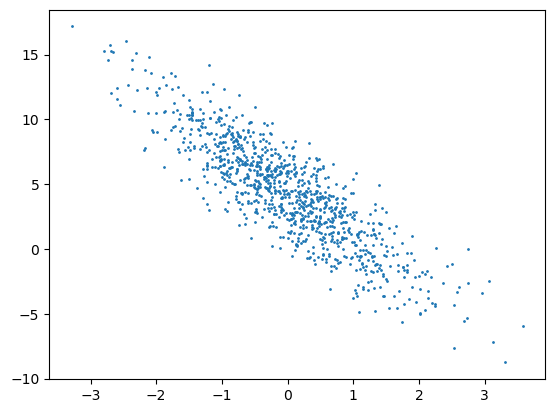

In [2]:
import torch
import random
import matplotlib.pyplot as plt

# Manully generate a linearRegression single layer neural network
# ---------------------------------------------------------------
# datasets
def synthetic_dataset(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))  # generate binary features
    y = torch.matmul(X, w) + b  # generate labels
    y += torch.normal(0, 0.01, y.shape)  # tune labels a little bit
    return X, y.reshape((-1, 1))
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_dataset(true_w, true_b, 1000)

# visualization
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)  # visualize the second feature and label to check linear correlation

In [3]:
# Optimization: Mini-batch Stochastic Gradient Descent

# Algorithm:
# 1. randomize index of features
# 2. iterate every batches coming from original feature list
# 3. in every iteration, output indices of every batch
def MSGD(features, labels, batch_size):
    num_examples = len(features)         # get features size
    indices = list(range(num_examples))  # get origninal indices
    random.shuffle(indices)              # shuffle indices randomly
    for i in range(0, num_examples, batch_size):   # for every batches, 
        batch_indces = torch.tensor(indices[i:min(i+batch_size, num_examples)])  # get every new random batches indices
        yield features[batch_indces], labels[batch_indces]                       # return batches generator

batch_size = 10
for X, y in MSGD(features, labels, batch_size):
    print(X,'\n', X.shape)
    print(y,'\n', y.shape)
    break
print(MSGD(features, labels, batch_size))

tensor([[ 0.4746, -1.3997],
        [-1.1092,  0.2116],
        [ 0.5008,  0.5673],
        [-1.1937, -0.7690],
        [ 0.8587, -0.3110],
        [ 1.4993, -0.2830],
        [ 1.3540, -0.4267],
        [-1.1843,  1.2639],
        [ 1.6339,  0.0947],
        [-2.0999, -1.3727]]) 
 torch.Size([10, 2])
tensor([[ 9.9185],
        [ 1.2639],
        [ 3.2731],
        [ 4.4144],
        [ 6.9762],
        [ 8.1729],
        [ 8.3738],
        [-2.4670],
        [ 7.1431],
        [ 4.6744]]) 
 torch.Size([10, 1])
<generator object MSGD at 0x000002900291B990>


In [4]:
# Initialization of parameters
# standard normal distribution: mean 0, std 0.01
w = torch.normal(0 ,0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# model algorithm
def linearRegression(X, w, b):
    return torch.matmul(X, w) + b

# loss function
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# optimization
def optimize(params, learningRate, batch_size):
    with torch.no_grad():
        for param in params:
            param -=learningRate * param.grad / batch_size  # update w and b with learning rate and batch size
            param.grad.zero_()                              # reduction of gradient

# training
lr = 0.03
epochs = 3

# training algorithm
# 1. predict y_hat
# 2. compute loss 
# 3. compute gradient of loss
# 4. optimize by reduction of gradients with learning rate and batch size
for epoch in range(epochs):
    for X, y in MSGD(features, labels, batch_size):
        y_hat = linearRegression(X, w, b)
        loss = squared_loss(y_hat, y)
        loss.sum().backward()   # when start using backward(), torch will compute gradients underneath
        optimize([w, b], lr, batch_size)
    with torch.no_grad():       # using torch.no_grad() to stop gradient computing and reduce memory comsumption
        train_loss = squared_loss(linearRegression(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_loss.mean()):f}')

print(f'w estimated error: {true_w - w.reshape(true_w.shape)}')
print(f'b estimated error: {true_b - b}:f')

epoch 1, loss 0.028493
epoch 2, loss 0.000094
epoch 3, loss 0.000048
w estimated error: tensor([-1.9503e-04,  1.3828e-05], grad_fn=<SubBackward0>)
b estimated error: tensor([0.0002], grad_fn=<RsubBackward1>):f


In [5]:
import numpy as np
import torch
from torch.utils import data

# Torch single layer neural network(linear regression)
# --------------------

# datasets
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_dataset(true_w, true_b, 1000)

# Mini-batch Stochastic Gradient Descent
# 1. transform original dataset to torch's tensor dataset
# 2. load dataset as batches using DataLoader
def MSGD(dataset, batch_size, is_train=True):
    dataset_tensor = data.TensorDataset(*dataset)
    return data.DataLoader(dataset_tensor, batch_size, shuffle=is_train)

batch_size = 10
mini_dataset = MSGD((features, labels), batch_size)
next(iter(mini_dataset))      # we use iterator and next to access first part of iteration of dataset

[tensor([[ 0.6542, -0.7904],
         [ 0.8145, -1.3162],
         [ 1.6109,  1.2233],
         [ 0.5114,  0.5164],
         [ 0.8379,  0.2587],
         [-0.0665,  0.6003],
         [-0.1344, -0.0620],
         [-0.4113, -0.1173],
         [ 0.8138,  1.5856],
         [-0.6082,  0.9230]]),
 tensor([[ 8.2009],
         [10.3037],
         [ 3.2830],
         [ 3.4759],
         [ 4.9989],
         [ 2.0324],
         [ 4.1637],
         [ 3.7757],
         [ 0.4309],
         [-0.1625]])]

In [6]:
# model
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))   # in_features(shape): int, out_features(shape): int

# initialize parameters
# 1. access weights of nn by net[layer].weight.data
# 2. access bias of nn by net[layer].bias.data
# 3. rewrite parameter by calling normal_ and fill_ function
net[0].weight.data.normal_(0, 0.01)    # index[0] to access first layer of neural network
net[0].bias.data.fill_(0)

# loss function
loss = nn.MSELoss()

# optimization
# 1. SGD function: parameters, learning rate
# 2. access parameters by net.parameters() method
optimization = torch.optim.SGD(net.parameters(), lr=0.03)

# train
epochs = 3
for epoch in range(epochs):
    for X, y in mini_dataset:
        y_hat = net(X)
        l = loss(y_hat, y)
        optimization.zero_grad()
        l.backward()
        optimization.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

w = net[0].weight.data
b = net[0].bias.data
print(f'w estimated error: {true_w - w.reshape(true_w.shape)}:f')
print(f'b estimated error: {true_b - b}:f')

epoch 1, loss 0.000177
epoch 2, loss 0.000099
epoch 3, loss 0.000100
w estimated error: tensor([-1.0536e-03,  9.9421e-05]):f
b estimated error: tensor([-0.0005]):f
